In [1]:
import numpy as np
import scipy
from sklearn import metrics
from numpy import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster, preprocessing, decomposition
from scipy.sparse import csgraph
from tensorflow.keras import layers
%matplotlib inline

### 将每个像素点作为graph中的结点，然后随机采样400个结点，每个结点连接最近的8个结点，生成对应的graph

In [2]:
def generate_grid_graph(m, k=8, num_samples=400):
    #生成m*m的图像中每个像素点的坐标
    M = m**2
    x = np.linspace(0, 1, m, dtype=np.float32)
    y = np.linspace(0, 1, m, dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    z = np.empty((M, 2), np.float32)
    z[:, 0] = xx.reshape(M)
    z[:, 1] = yy.reshape(M)
    
    # 随机选择部分结点
    sample_inds = random.choice(range(M), num_samples, False)
    sample_inds.sort()
    z_sample = z[sample_inds, :]
    
    #计算像素点之间的距离
    dist = metrics.pairwise_distances(
        z_sample, metric='euclidean')
    #取前k个最近邻结点 k-NN graph.
    idx = np.argsort(dist)[:, 1:k+1] #前k个最近邻结点的idx
    dist.sort()
    dist = dist[:, 1:k+1] #前k个最近邻结点的距离
    
    # 根据距离计算边的权重
    sigma2 = np.mean(dist[:, -1])**2
    dist = np.exp(- dist**2 / sigma2)

    # 权重矩阵
    I = np.arange(0, num_samples).repeat(k)
    J = idx.reshape(num_samples*k)
    V = dist.reshape(num_samples*k)
    W = scipy.sparse.coo_matrix((V, (I, J)), shape=(num_samples, num_samples))

    # 去除自连接
    W.setdiag(0)

    # 数值计算问题，引起的矩阵不对称，修正这一问题
    bigger = W.T > W
    W = W - W.multiply(bigger) + W.T.multiply(bigger)
    
    return sample_inds, W

In [3]:
img_width = 28
sample_inds, W_sample = generate_grid_graph(28)

### 读取MNIST数据

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
x_train_sample = x_train.reshape(x_train.shape[0], -1, 1).astype(np.float32)[:, sample_inds]/255.0
x_test_sample = x_test.reshape(x_test.shape[0], -1, 1).astype(np.float32)[:, sample_inds]/255.0

#### 可视化采样后的图像

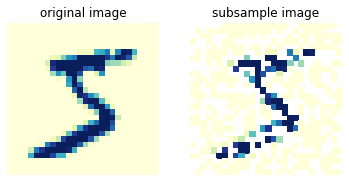

In [6]:
f, axes = plt.subplots(1, 2)
minist_img = x_train[0]
mask = np.zeros_like(minist_img).reshape(-1)
mask += 1
mask[sample_inds] = 0
minist_img = minist_img.reshape(img_width, img_width)
mask = mask.astype(np.bool).reshape(img_width, img_width)

fig1 = sns.heatmap(minist_img, cmap="YlGnBu", ax=axes[0], xticklabels=False, yticklabels=False, cbar=False, square=True).set_title("original image")
fig2 = sns.heatmap(minist_img, mask=mask, cmap="YlGnBu", ax=axes[1], xticklabels=False, yticklabels=False, cbar=False, square=True).set_title("subsample image")

### 空域卷积

In [7]:
class SpatialConvolution(layers.Layer):
    def __init__(self, graph, fin, fout, w_init):
        super(SpatialConvolution, self).__init__()
        self.fin = fin
        self.fout = fout
        self.num_node = graph.shape[0]
        w_init = w_init(stddev=np.sqrt(2.0/self.fin))
        nonzero_inds = np.stack(np.nonzero(graph), axis=1) 
        weights = tf.Variable(initial_value=w_init(shape=(fin*fout*len(nonzero_inds), ),
                                                  dtype='float32'),
                             trainable=True)
        indices = []
        for i in range(fin):
            for j in range(fout):
                fin_ind = np.repeat([[i]], repeats=len(nonzero_inds), axis=0)
                fout_ind = np.repeat([[j]], repeats=len(nonzero_inds), axis=0)
                new_nonzero_inds = np.concatenate([fout_ind, nonzero_inds, fin_ind], axis=1)
                indices.append(new_nonzero_inds)
        indices = np.concatenate(indices, axis=0)

        F = tf.sparse.SparseTensor(indices, tf.identity(weights), (fout, self.num_node, self.num_node, fin))
        self.F_tran_reshape = tf.sparse.reorder(tf.sparse.reshape(F, shape=(fout*self.num_node, self.num_node*fin)))
    
    def call(self, inputs):
        inputs_reshape = tf.transpose(tf.reshape(inputs, shape=(-1, self.fin*self.num_node)))
        c1 = tf.sparse.sparse_dense_matmul(self.F_tran_reshape, inputs_reshape)
        output = tf.nn.relu(c1)
        output = tf.reshape(tf.transpose(output), (-1, self.num_node, self.fout))
        return output

### avg pooling

In [8]:
class AvgPooling(layers.Layer):
    def __init__(self, graph, fout):
        super(AvgPooling, self).__init__()
        num_node = graph.shape[0]
        cluster_ids = cluster.spectral_clustering(graph, n_clusters=fout)
        cluster_ids2node_ids = [[] for i in range(fout)]
        for node_id, cluster_id in enumerate(cluster_ids):
            cluster_ids2node_ids[cluster_id].append(node_id)

        new_graph = np.zeros((fout, fout), dtype=np.float32)
        for cluster_id_i, nodes_ids_i in enumerate(cluster_ids2node_ids):
            for cluster_id_j, nodes_ids_j in enumerate(cluster_ids2node_ids):
                for node_id_i in nodes_ids_i:
                    for node_id_j in nodes_ids_j:
                        new_graph[cluster_id_i, cluster_id_j] += graph[node_id_i, node_id_j]
        self.graph = preprocessing.normalize(new_graph, norm='l1', axis=1)

        self.node2cluster_matrix = np.zeros((num_node, fout), dtype=np.float32)
        for cluster_id, node_ids in enumerate(cluster_ids2node_ids):
            self.node2cluster_matrix[node_ids, cluster_id] = 1.0/len(node_ids)
            
    def get_graph(self):
        return self.graph
    
    def call(self, inputs):
        output = tf.transpose(tf.tensordot(inputs, self.node2cluster_matrix, axes=[[1], [0]]), perm=[0, 2, 1])
        return output

### 频域卷积

In [26]:
class SpectralConvolution(layers.Layer):
    def __init__(self, graph, fin, fout, n_component, w_init):
        super(SpectralConvolution, self).__init__()
        self.num_node = graph.shape[0]
        self.fin = fin
        self.fout = fout
        self.n_component = n_component
        w_init = w_init(stddev=np.sqrt(2.0/self.fin))
        laplacian_graph = csgraph.laplacian(graph, normed=False)
        eigen_value, eigen_vector = np.linalg.eig(laplacian_graph.todense())
        idx = eigen_value.argsort()[::-1]   
        eigen_value = eigen_value[idx][-self.n_component:]
        eigen_vector = eigen_vector[:,idx][:, -self.n_component:]
        
        self.u = eigen_vector.T

        weights = tf.Variable(initial_value=w_init(shape=(fin*fout*self.n_component, ),
                                                  dtype='float32'),
                             trainable=True)
        indices = []
        for i in range(fin):
            for j in range(fout):
                fin_ind = np.repeat([[i]], repeats=self.n_component, axis=0)
                fout_ind = np.repeat([[i]], repeats=self.n_component, axis=0)
                nonzero_inds = np.array([[k, k] for k in range(self.n_component)], dtype=np.int32)
                new_nonzero_inds = np.concatenate([fout_ind, nonzero_inds, fin_ind], axis=1)
                indices.append(new_nonzero_inds)
        indices = np.concatenate(indices, axis=0)

        F = tf.sparse.SparseTensor(indices, tf.identity(weights), (fout, self.n_component, self.n_component, fin))
        self.F_tran_reshape = tf.sparse.reorder(tf.sparse.reshape(F, shape=(fout*self.n_component, self.n_component*fin)))
    
    def call(self, inputs):
        inputs_spectral = tf.tensordot(inputs, self.u, axes=[[1], [1]])
        inputs_spectral_reshape = tf.transpose(tf.reshape(inputs_spectral, shape=(-1, self.fin*self.n_component)))
        F_output = tf.transpose(tf.sparse.sparse_dense_matmul(self.F_tran_reshape, inputs_spectral_reshape))
        F_output = tf.reshape(F_output, (-1, self.fout, self.n_component))
        c1 = tf.transpose(tf.tensordot(F_output, self.u, axes=[[2], [0]]), perm=[0, 2, 1])
        output = tf.nn.relu(c1)
        return output

### 空域图卷积模型

In [10]:
class SpatialGCN(tf.keras.Model):
    def __init__(self, graph, num_classes=10):
        super(SpatialGCN, self).__init__()
        w_init = tf.random_normal_initializer
        self.lrf_3200 = SpatialConvolution(graph, 1, 8, w_init)
        self.ap_800 = AvgPooling(graph, 100)
        graph_100 = self.ap_800.get_graph()
        self.lrf_800 = SpatialConvolution(graph_100, 8, 8, w_init)
        self.ap_400 = AvgPooling(graph_100, 50)
        self.fc = layers.Dense(num_classes)
        
    def call(self, inputs):
        lrf_3200_output = self.lrf_3200(inputs)
        ap_800_output = self.ap_800(lrf_3200_output)
        lrf_800_output = self.lrf_800(ap_800_output)
        ap_400_output = self.ap_400(lrf_800_output)
        ap_400_output_reshape = tf.reshape(ap_400_output, (-1, 400))
        logits = self.fc(ap_400_output_reshape)
        predictions = tf.nn.softmax(logits)
        return predictions

### 频域图卷积模型

In [22]:
class SpectralGCN(tf.keras.Model):
    def __init__(self, graph, num_classes=10):
        super(SpectralGCN, self).__init__()
        w_init = tf.random_normal_initializer
        self.sp_1600 = SpectralConvolution(graph, 1, 4, 300, w_init)
        self.fc = layers.Dense(num_classes)
        
    def call(self, inputs):
        sp_1600_output = self.sp_1600(inputs)
        sp_1600_output_reshape = tf.reshape(sp_1600_output, (-1, 1600))
        logits = self.fc(sp_1600_output_reshape)
        predictions = tf.nn.softmax(logits)
        return predictions

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

In [28]:
model = SpatialGCN(W_sample)
model.compile(optimizer, loss=loss_fn, metrics=metrics)
model.fit(x_train_sample, y_train, epochs=50, batch_size=128, validation_data=(x_test_sample, y_test))

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:855: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 66us/sample - loss: 0.4548 - sparse_categorical_accuracy: 0.8631 - val_loss: 0.3034 - val_sparse_categorical_accuracy: 0.9140
Epoch 2/50
60000/60000 [==============================] - 3s 57us/sample - loss: 0.2939 - sparse_categorical_accuracy: 0.9141 - val_loss: 0.2592 - val_sparse_categorical_accuracy: 0.9238
Epoch 3/50
60000/60000 [==============================] - 3s 57us/sample - loss: 0.2626 - sparse_categorical_accuracy: 0.9228 - val_loss: 0.2418 - val_sparse_categorical_accuracy: 0.9283
Epoch 4/50
60000/60000 [==============================] - 3s 56us/sample - loss: 0.2443 - sparse_categorical_accuracy: 0.9287 - val_loss: 0.2302 - val_sparse_categorical_accuracy: 0.9307
Epoch 5/50
60000/60000 [==============================] - 3s 56us/sample - loss: 0.2311 - sparse_categorical_accuracy: 0.9322 - val_loss: 0.2243 - val_sparse_categorical_accuracy: 0.9335
Epoch 6/50
6000

## 可视化第二个avg pooling的聚类结果

In [83]:
node2clusterid = model.ap_800.node2cluster_matrix.dot(model.ap_400.node2cluster_matrix)

In [89]:
def draw_cluster_result(node2clusterid):
    kernel_img = np.zeros((img_width, img_width), dtype=np.float32)
    for i in range(len(sample_inds)):
        ind = sample_inds[i]
        row = ind//img_width
        col = ind%img_width
        cluster_id = np.argmax(node2clusterid[i, :])+1
        kernel_img[row, col] = cluster_id
        sns.heatmap(kernel_img, mask=mask, cmap=sns.color_palette("Paired"), xticklabels=False, yticklabels=False, cbar=False, square=True).set_title("cluster result with cluster number %s" % node2clusterid.shape[1])

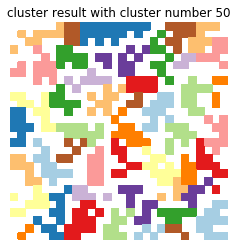

In [90]:
draw_cluster_result(node2clusterid)

In [27]:
model = SpectralGCN(W_sample)
model.compile(optimizer, loss=loss_fn, metrics=metrics)
model.fit(x_train_sample, y_train, epochs=50, batch_size=128, validation_data=(x_test_sample, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 37us/sample - loss: 0.4600 - sparse_categorical_accuracy: 0.8676 - val_loss: 0.3302 - val_sparse_categorical_accuracy: 0.9052
Epoch 2/50
60000/60000 [==============================] - 2s 30us/sample - loss: 0.3244 - sparse_categorical_accuracy: 0.9059 - val_loss: 0.2984 - val_sparse_categorical_accuracy: 0.9153
Epoch 3/50
60000/60000 [==============================] - 2s 31us/sample - loss: 0.2971 - sparse_categorical_accuracy: 0.9146 - val_loss: 0.2825 - val_sparse_categorical_accuracy: 0.9183
Epoch 4/50
60000/60000 [==============================] - 2s 31us/sample - loss: 0.2808 - sparse_categorical_accuracy: 0.9183 - val_loss: 0.2738 - val_sparse_categorical_accuracy: 0.9187
Epoch 5/50
60000/60000 [==============================] - 2s 31us/sample - loss: 0.2703 - sparse_categorical_accuracy: 0.9213 - val_loss: 0.2668 - val_sparse_categorical_accuracy: 0.9226
Epoch 6/50
6000